# Problem set 3. Transitions for Hugget: Debt and Pareto Improvements

Manuel Amador

Python 3.11.3

You can install anaconda: 

https://www.anaconda.com/

More details on installation in Sargent and Stachurski Quantecon's website:

http://quant-econ.net/py/index.html

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rc("savefig", dpi=120)
import numba as nb
import time

In [2]:
beta= 0.95
rho = 2
phi = 0
n = 2 # number of endowment shocks
p = np.array([[.5, .5], 
              [0.2, 0.8]])  # transition probability for the endowment shocks
y_grid = np.array([0.5, 1.0]) # endowment shocks


grid_points = 10000 # for the asset holdings 
a_max = 5  # this is just a guess
a_min = 0
a_grid = np.linspace(a_min, a_max, grid_points) # grid for ahat

In [3]:
@nb.jit
def u(c):
    return c ** (1 - rho) / (1 - rho) 

@nb.jit
def solve_household(R, tolerance=10**(-4)):
    v_0 = np.zeros((grid_points, n))
    v_1 = np.empty((grid_points, n))
    pol_1 = np.empty((grid_points, n), dtype=np.int32)
    beta_v_exp = np.empty((grid_points, n))
    iter = 0
    while True:
        distance = 0.0
        iter += 1
        for s in range(n):  # pre-computing the expected value term
            for i in range(grid_points):
                accum = 0.0
                for sprime in range(n):
                    accum = accum + beta * p[s, sprime] * v_0[i, sprime]
                beta_v_exp[i, s] = accum
        for s in range(n):  # doing the optimization
            pol = 0
            for i in range(grid_points):
                just_started = True
                j = pol # policy is monotonic -- start from the previous optimal policy
                while j < grid_points:
                    c = R * a_grid[i] + y_grid[s] - a_grid[j]
                    if c > 0.0:
                        temp = u(c) + beta_v_exp[j, s] 
                        if just_started:
                            vmax = temp
                            pol = j
                            just_started = False
                        elif temp > vmax:
                            vmax = temp
                            pol = j
                        else:
                            # value decreased -- concavity means it can't go up again
                            break
                    j += 1
                v_1[i, s] = vmax
                pol_1[i, s] = pol
                dis = abs(vmax - v_0[i, s])
                if dis > distance: 
                    distance = dis
        if distance < tolerance:
            break
        else:
            temp2 = v_0
            v_0 = v_1
            v_1 = temp2
    return v_1, pol_1


@nb.jit
def get_stationary_distribution(policy, tolerance=10**(-7)):
    pdf_0 = np.ones((grid_points, n)) / (grid_points * n)
    while True:
        pdf_1 = np.zeros((grid_points, n))
        for i in range(grid_points):
            for s in range(n):
                for sprime in range(n):
                    pdf_1[policy[i, s], sprime] += p[s, sprime] * pdf_0[i, s]
        distance = 0.0
        for i in range(grid_points):
            for s in range(n):
                distance = max(abs(pdf_1[i, s] - pdf_0[i, s]), distance)
        if distance - tolerance < 0:
            break
        else:
            pdf_0 = pdf_1
    return pdf_1


def do_pdf_plots(pdf_ss):
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    pdf_assets = np.zeros((grid_points)) 
    for i in range(grid_points):
            pdf_assets[i] = np.sum(pdf_ss[i, :])
    plt.plot(a_grid, pdf_assets)
    plt.xlabel('$\hat{a}$', fontsize=16)
    plt.title('Stationary PDF over assets');

    plt.subplot(122)
    plt.plot(a_grid, np.cumsum(pdf_assets), lw = 1)
    plt.xlabel('$\hat{a}$', fontsize=16)
    plt.title('Stationary CDF over assets')


def find_R_bar():
    # to be completed by the students
    return 0.5 # this is a made up number




In [4]:
Rbar = find_R_bar() ## To be completed 

valueA, policyA = solve_household(Rbar)
pdf_ssA = get_stationary_distribution(policyA)


valueB, policyB = solve_household(1.0)
pdf_ssB = get_stationary_distribution(policyB)

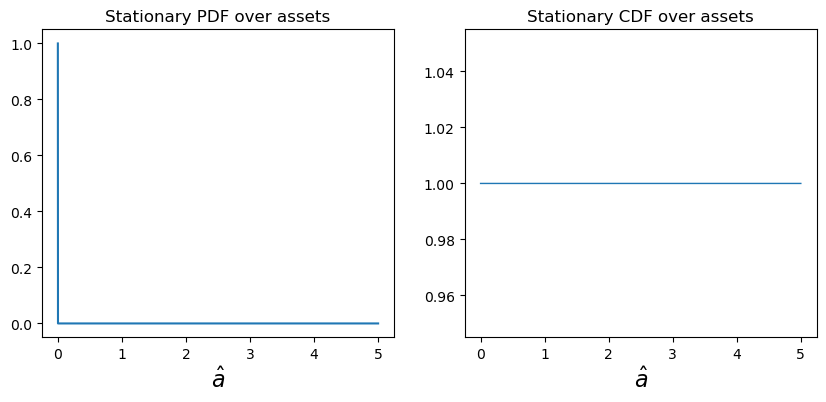

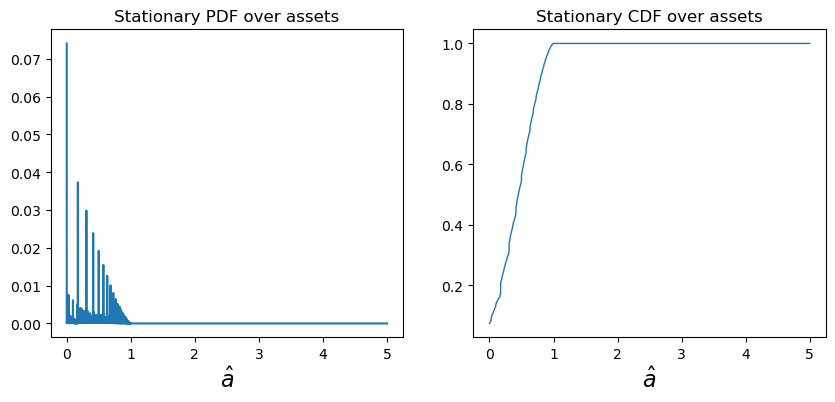

In [5]:
do_pdf_plots(pdf_ssA)
do_pdf_plots(pdf_ssB)